In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as sig
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

#plt.style.use('ggplot')
plt.style.use('seaborn')

#sns.set_style('white')

/tmp/ipykernel_6711/2977597368.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [33]:
spikes = np.load("spikes-10e4-ms.npy")

N = np.shape(spikes)[0]
wup_time = 1000
spikes = spikes[:, wup_time:]
sim_dur = np.shape(spikes)[1]

noise_intra = np.random.normal(0, 0.01, (N, sim_dur))
spikes_noisy = spikes + noise_intra

calcium = np.zeros((N, sim_dur))
calcium_nsp = np.zeros((N, sim_dur))
tau = 100
dt = 1
const_A = np.exp((-1/tau)*dt)

calcium[:, 0] = spikes[:, 0]
calcium_nsp[:, 0] = spikes[:, 0]

for t in range(1, sim_dur):
    calcium[:, t] = const_A*calcium[:, t-1] + spikes[:, t]


for t in range(1, sim_dur):
    calcium_nsp[:, t] = const_A*calcium_nsp[:, t-1] + spikes_noisy[:, t]


In [34]:
np.shape(spikes)

(1250, 9000)

In [35]:
n = 500
#calciumN = calcium[n, :]
noise_recording = np.random.normal(0,1, (N, sim_dur))
calcium_noisy = calcium + noise_recording

#calciumN_nsp = calcium_nsp[n, :]
#noise = np.random.normal(0,1, sim_dur)
calcium_nsp_noisy = calcium_nsp + noise_recording

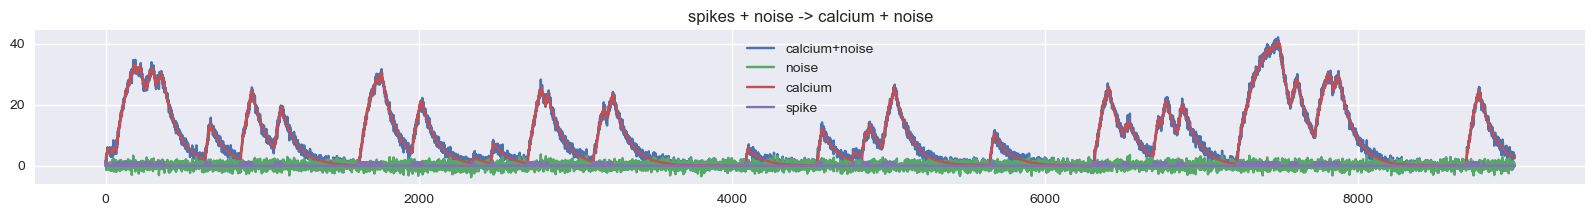

In [37]:
f = plt.figure(figsize=(20,2)) #figure size inside
#ax1 = f.add_axes() #axis limits inside when there is no subplots
#ax1 = plt.subplot(2,1,1) when you want to share axes between subplots you don't use this
ax2 = f.subplots(1)

ax2.set_title('spikes + noise -> calcium + noise')
ax2.plot(calcium_nsp_noisy[n, :], label = 'calcium+noise')
ax2.plot(noise_recording[n, :], label = 'noise')
ax2.plot(calcium_nsp[n, :], label = 'calcium')
ax2.plot(spikes_noisy[n, :], label = 'spike')
ax2.legend()


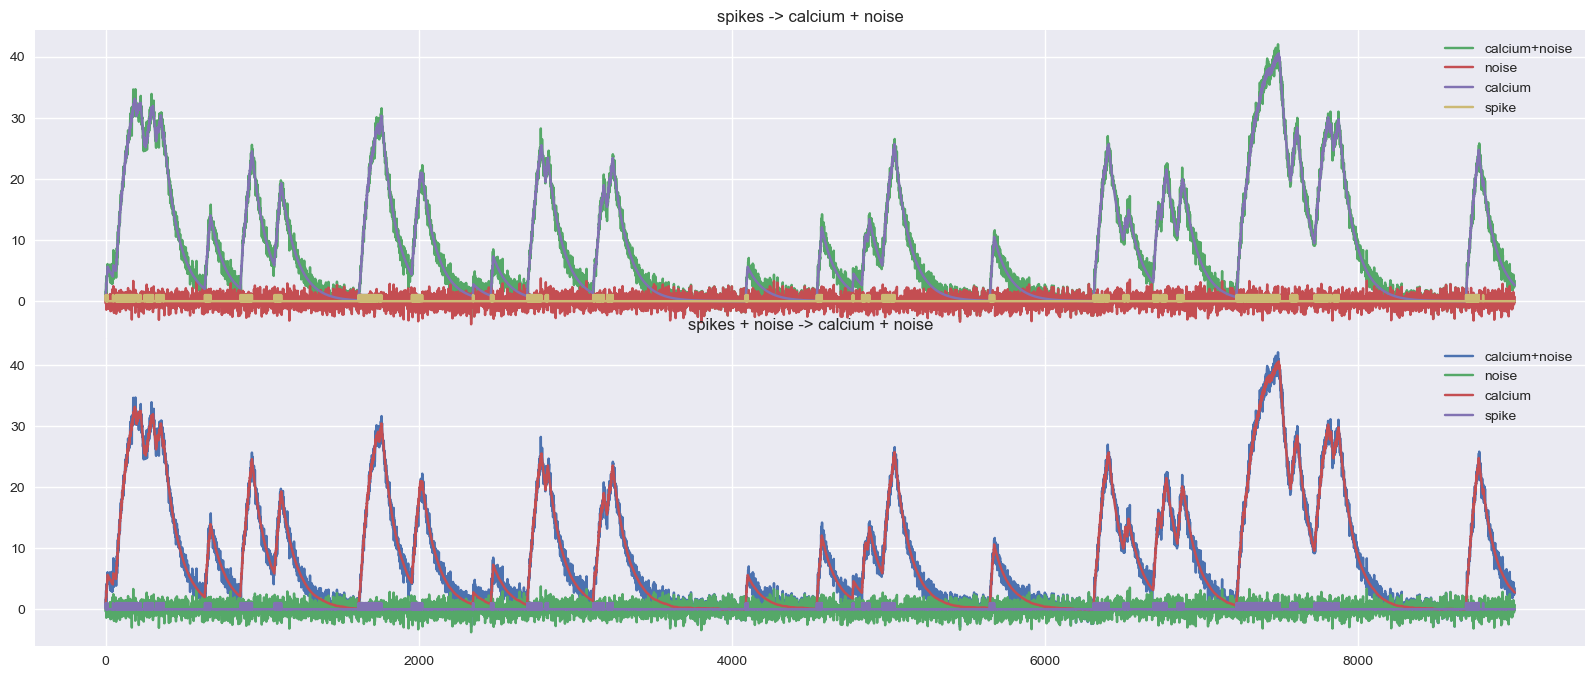

In [38]:
f = plt.figure(figsize=(20,8)) #figure size inside
#ax1 = f.add_axes() #axis limits inside when there is no subplots
#ax1 = plt.subplot(2,1,1) when you want to share axes between subplots you don't use this
(ax1, ax2) = f.subplots(2, sharex=True)

ax1.set_title('spikes -> calcium + noise')
ax1.plot(spikes[n, :])
ax1.plot(calcium_noisy[n, :], label = 'calcium+noise')
ax1.plot(noise_recording[n, :], label = 'noise')
ax1.plot(calcium[n, :], label = 'calcium')
ax1.plot(spikes[n, :], label = 'spike')
ax1.legend()

ax2.set_title('spikes + noise -> calcium + noise')
ax2.plot(calcium_nsp_noisy[n, :], label = 'calcium+noise')
ax2.plot(noise_recording[n, :], label = 'noise')
ax2.plot(calcium_nsp[n, :], label = 'calcium')
ax2.plot(spikes_noisy[n, :], label = 'spike')
ax2.legend()

f.subplots_adjust(hspace=0)


Denoising by savitzky filter for signal and its first derivation and putting them into the exact solution of first order eq. works well. the only difference is the sign.

In [29]:
smooth_cal = sig.savgol_filter(calcium_noisy[n, :], window_length=31, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(calcium_noisy[n, :], window_length=31, deriv=1, delta=1., polyorder=3)

x_nc = smooth_deriv + (1/tau)*smooth_cal

In [39]:
smooth_cal = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=11, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=11, deriv=1, delta=1., polyorder=3)

x_ncsp = smooth_deriv + (1/tau)*smooth_cal

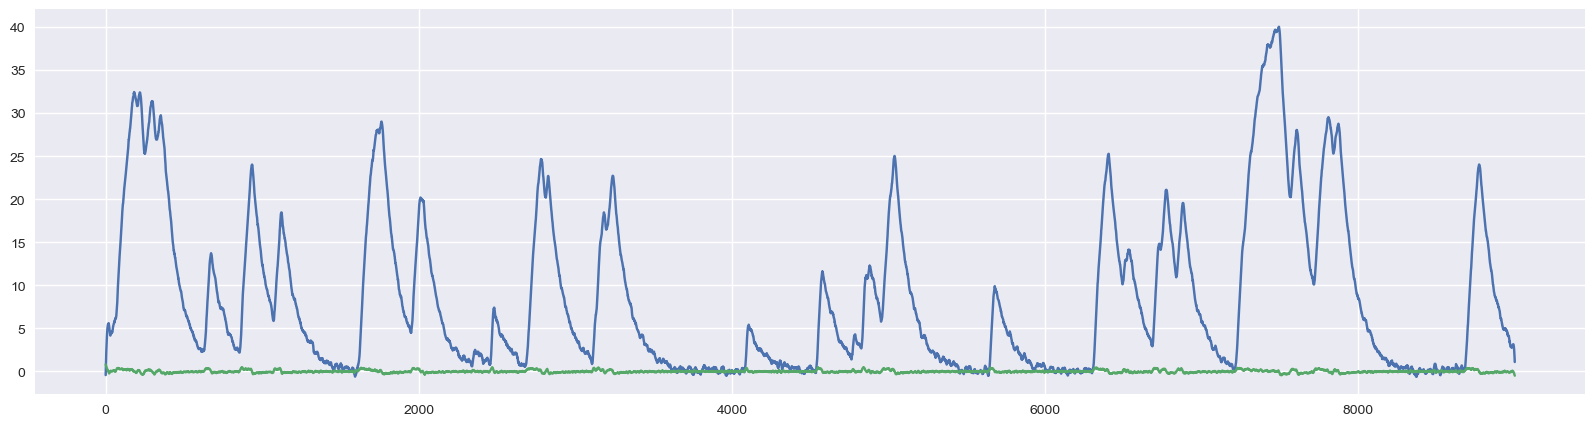

In [9]:
plt.figure(figsize=(20, 5))
plt.plot(smooth_cal)
plt.plot(smooth_deriv)

 α ẏ(t) + β y(t)  =  x(t)

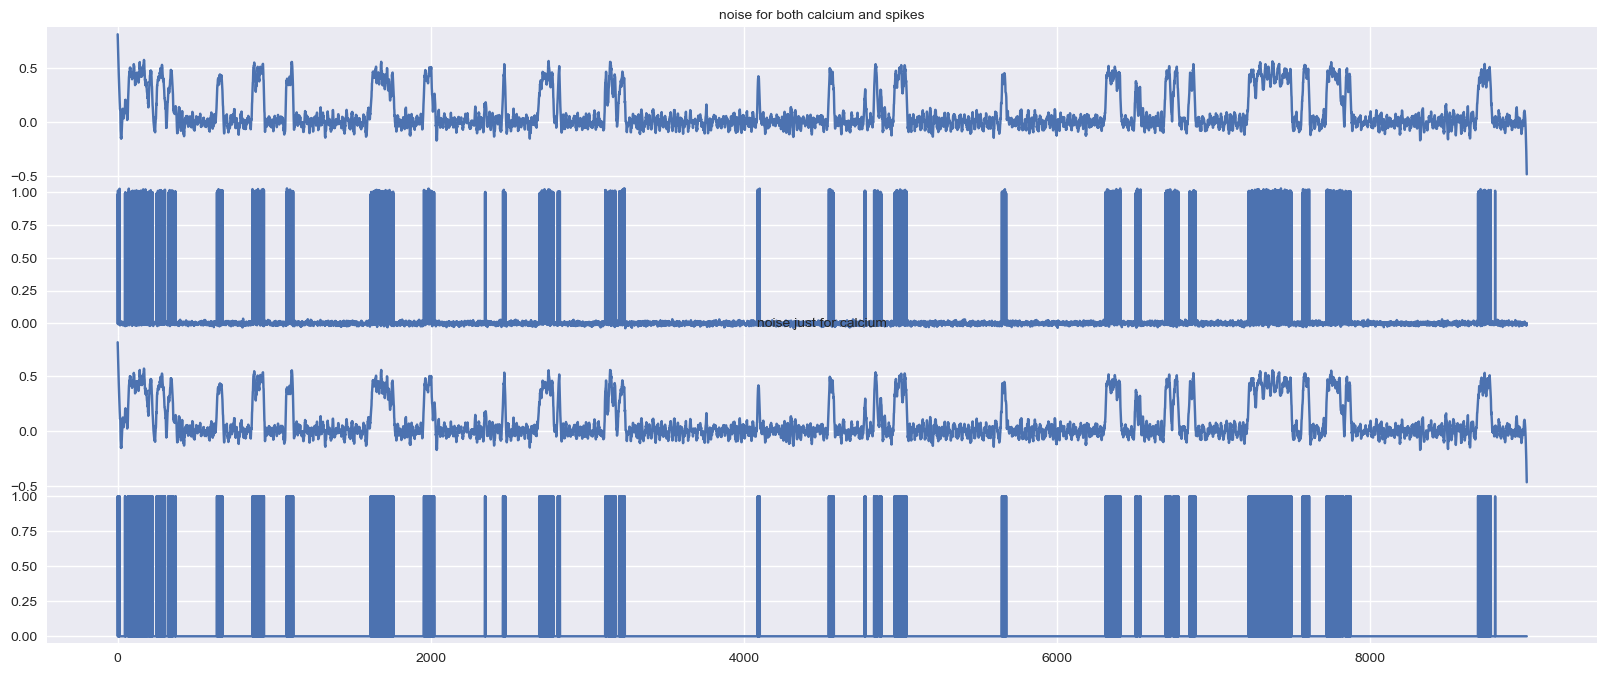

In [10]:
f = plt.figure(figsize=(20,8))
(ax1, ax2, ax3, ax4) = f.subplots(4, sharex=True)

ax1.plot(x_ncsp)
ax1.set_title("noise for both calcium and spikes", fontsize = 10)
ax2.plot(spikes_noisy[n, :])
ax3.plot(x_nc)
ax3.set_title("noise just for calcium", fontsize = 10)
ax4.plot(spikes[n, :])

plt.subplots_adjust(hspace=0)

In [11]:
np.corrcoef(spikes[n, :], x_ncsp)

array([[1.        , 0.56153391],
       [0.56153391, 1.        ]])

In [12]:
np.corrcoef(x_nc, x_ncsp)

array([[1.        , 0.99986321],
       [0.99986321, 1.        ]])

array([1.0056948 , 0.44226837])

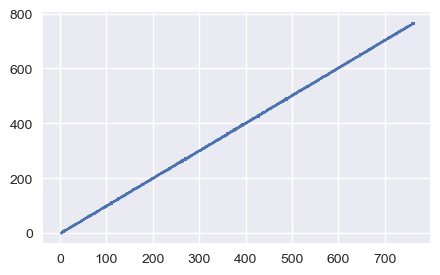

In [13]:
cum_spikes = np.cumsum(spikes[n, :])
cum_spikes_noisy = np.cumsum(spikes_noisy[n, :])
cum_x_ncsp = np.cumsum(x_ncsp)
cum_x_nc = np.cumsum(x_nc)

fit1 = np.polyfit(cum_spikes, cum_x_ncsp, 1)
y = fit1[0]*cum_spikes + fit1[1]

f = plt.figure(figsize=(5,3))
ax = f.subplots()
ax.scatter(cum_spikes, cum_x_ncsp, s=1)
#ax.plot(cum_spikes, y)
fit1

##### binnig

In [14]:
bin_size = 100
length_spike = int(np.shape(spikes)[1])
n_bins = int(np.shape(spikes)[1]/bin_size)
#dictionary of signals names 

binned_spike = np.zeros(n_bins)

c = 0
for i in range(0,n_bins):
    binned_spike[i] = np.sum(spikes[n, c:c+bin_size])
    c = c + bin_size


In [15]:
bin_size = 100
length_xnsp = int(np.shape(x_ncsp)[0])
n_bins = int(np.shape(x_ncsp)[0]/bin_size)
#dictionary of signals names 

binned_xnsp = np.zeros(n_bins)

c = 0
for i in range(0,n_bins):
    binned_xnsp[i] = np.sum(x_ncsp[c:c+bin_size])
    c = c + bin_size


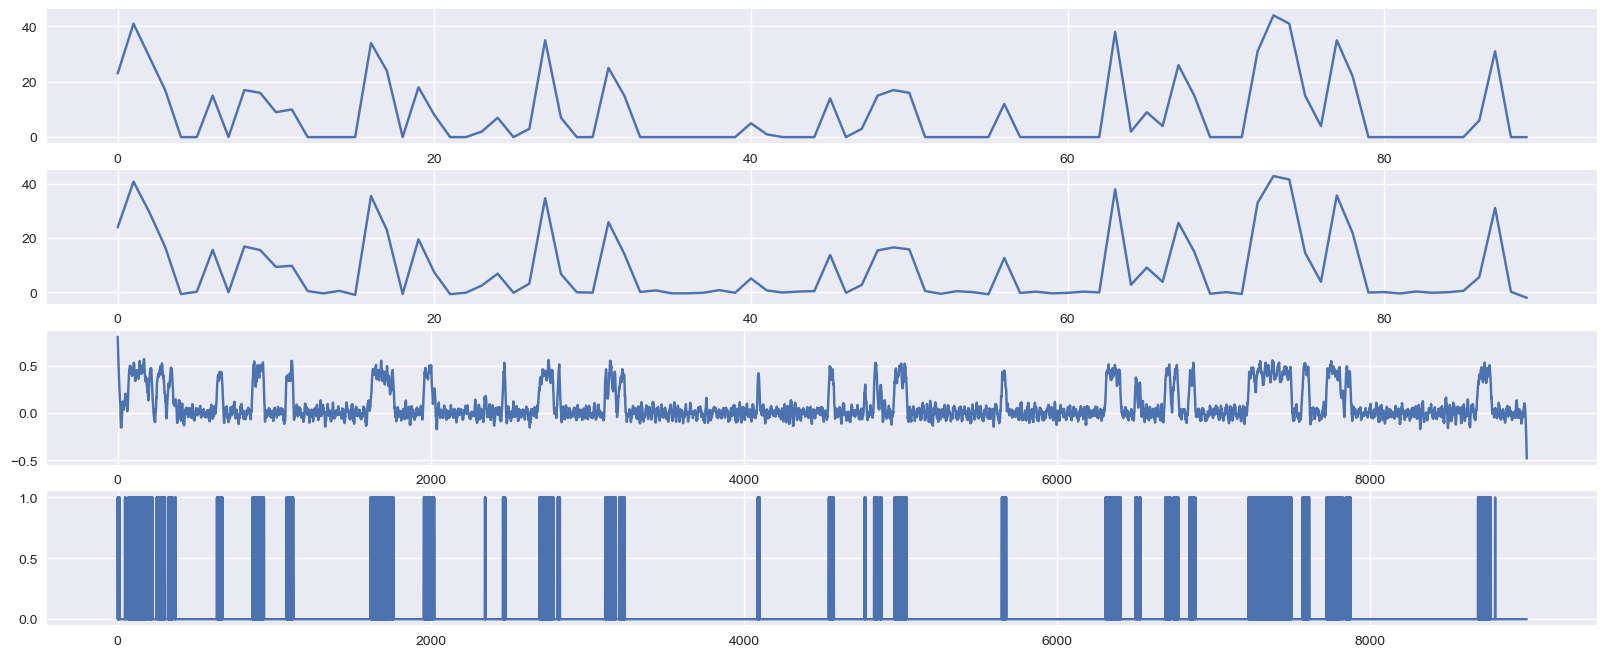

In [16]:
f = plt.figure(figsize=(20,8))
ax1 , ax2, ax3 , ax4 = f.subplots(4)

ax1.plot(binned_spike)
ax2.plot(binned_xnsp)
ax3.plot(x_ncsp)
ax4.plot(spikes[n, :])



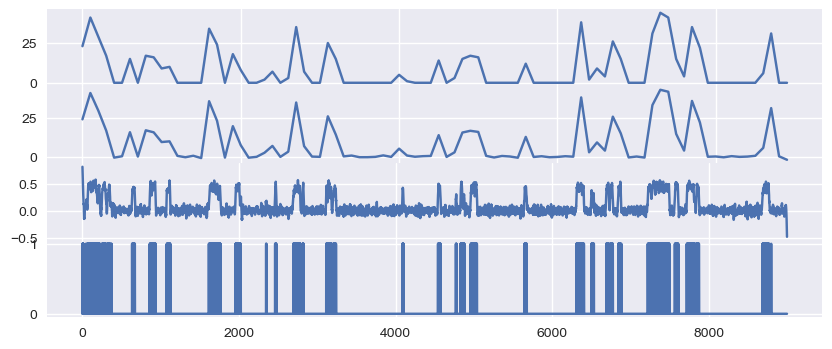

In [17]:
f = plt.figure(figsize=(10,4))
ax1 , ax2, ax3 , ax4 = f.subplots(4)

ax1.plot(binned_spike)
ax2.plot(binned_xnsp)
ax3.plot(x_ncsp)
ax4.plot(spikes[n, :])

plt.subplots_adjust(hspace=0)

### Connectivity Inference

In [18]:
noiseN = np.random.normal(0,1, (N, sim_dur))
noisy_cal = calcium + noiseN

#np.save('noisy_cal_10e4', noisy_cal)

In [28]:
smooth_cal = sig.savgol_filter(noisy_cal, window_length=31, deriv=0, delta=1., polyorder=5)
smooth_deriv = sig.savgol_filter(noisy_cal, window_length=31, deriv=1, delta=1., polyorder=5)

#denoised noisy_calcium which is going to inferene procedure
signal = smooth_deriv + (1/tau)*smooth_cal

np.corrcoef(spikes.flatten(), signal.flatten())[0, 1]

0.5152881045052656

In [10]:
#plt.figure()
plt.subplot(2,1,1)
plt.plot(signal[500, 1:8900])
plt.subplot(2,1,2)
plt.plot(spikes[500, 1:8900])

In [14]:
plt.plot(signal[500, 4000:5000], spikes[500, 4000:5000], '.')

In [20]:

G = np.load('connectivity-10e5-ms.npy')
G = G - (np.diag(np.diag(G)))

In [21]:
k = 10
Y = signal[:, k:]
Y_prime = signal[:, :-k]

yk = Y.T
y_k = Y_prime.T

np.shape(yk)

(98990, 1250)

In [22]:
reg = LinearRegression(n_jobs=-1).fit(y_k, yk)
a = reg.coef_
a = a - (np.diag(np.diag(a)))
np.corrcoef(G.flatten(), a.flatten())[0, 1]

0.5554727101379358

In [15]:
k = 10
Y = spikes[:, k:]
Y_prime = spikes[:, :-k]

yk = Y.T
y_k = Y_prime.T


reg = LinearRegression(n_jobs=-1).fit(y_k, yk)
a = reg.coef_
a = a - (np.diag(np.diag(a)))
np.corrcoef(G.flatten(), a.flatten())[0, 1]

0.40761319708918237

In [16]:
k = 10
Y = calcium[:, k:]
Y_prime = calcium[:, :-k]

yk = Y.T
y_k = Y_prime.T


reg = LinearRegression(n_jobs=-1).fit(y_k, yk)
a = reg.coef_
a = a - (np.diag(np.diag(a)))
np.corrcoef(G.flatten(), a.flatten())[0, 1]

0.48021036478665435

### Kernel fitting

In [4]:
spikes = np.load("spikes-10e4-ms.npy")

N = np.shape(spikes)[0]
wup_time = 1000
spikes = spikes[:, wup_time:]
sim_dur = np.shape(spikes)[1]

noise_intra = np.random.normal(0, 0.01, (N, sim_dur))
spikes_noisy = spikes + noise_intra

calcium = np.zeros((N, sim_dur))
calcium_nsp = np.zeros((N, sim_dur))
tau = 100
dt = 1
const_A = np.exp((-1/tau)*dt)

calcium[:, 0] = spikes[:, 0]
calcium_nsp[:, 0] = spikes[:, 0]

for t in range(1, sim_dur):
    calcium[:, t] = const_A*calcium[:, t-1] + spikes[:, t]


for t in range(1, sim_dur):
    calcium_nsp[:, t] = const_A*calcium_nsp[:, t-1] + spikes_noisy[:, t]


In [5]:
n = 500
#calciumN = calcium[n, :]
noise_recording = np.random.normal(0,1, (N, sim_dur))
calcium_noisy = calcium + noise_recording

#calciumN_nsp = calcium_nsp[n, :]
#noise = np.random.normal(0,1, sim_dur)
calcium_nsp_noisy = calcium_nsp + noise_recording

In [6]:
smooth_cal = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=11, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=11, deriv=1, delta=1., polyorder=3)

x_ncsp = smooth_deriv + (1/tau)*smooth_cal

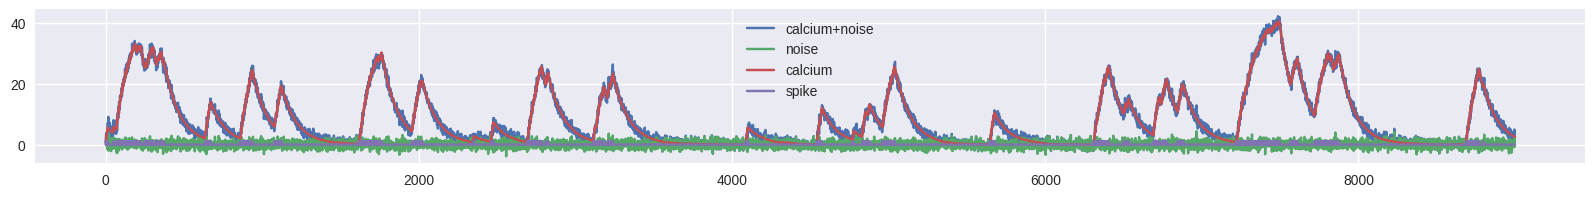

In [7]:
f = plt.figure(figsize=(20,2)) #figure size inside
#ax1 = f.add_axes() #axis limits inside when there is no subplots
#ax1 = plt.subplot(2,1,1) when you want to share axes between subplots you don't use this
ax2 = f.subplots(1)

# ax2.set_title('spikes + noise -> calcium + noise')
ax2.plot(calcium_nsp_noisy[n, :], label = 'calcium+noise')
ax2.plot(noise_recording[n, :], label = 'noise')
ax2.plot(calcium_nsp[n, :], label = 'calcium')
ax2.plot(spikes_noisy[n, :], label = 'spike')
ax2.legend()

In [15]:
from scipy.optimize import curve_fit

def func(t_test, A_test, tau_test):
    return A_test * np.exp(-t_test/tau_test)

array([176])

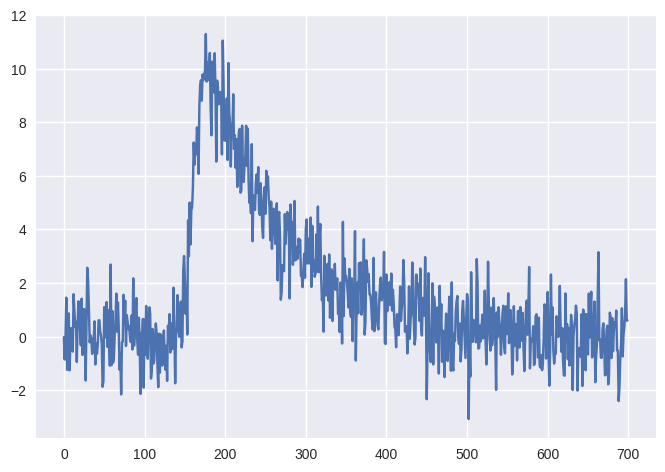

In [17]:
c_test1 = calcium_nsp_noisy[n, 5500:6200]
sav_test1 = smooth_cal[5500:6200]
savd_test1 = smooth_deriv[5500:6200]

plt.plot(c_test1)

np.where(c_test1 == np.max(c_test1))[0]

In [18]:
sav_test1 = sav_test1[179:]
savd_test1 = savd_test1[179:]

In [19]:
len(sav_test1)

521

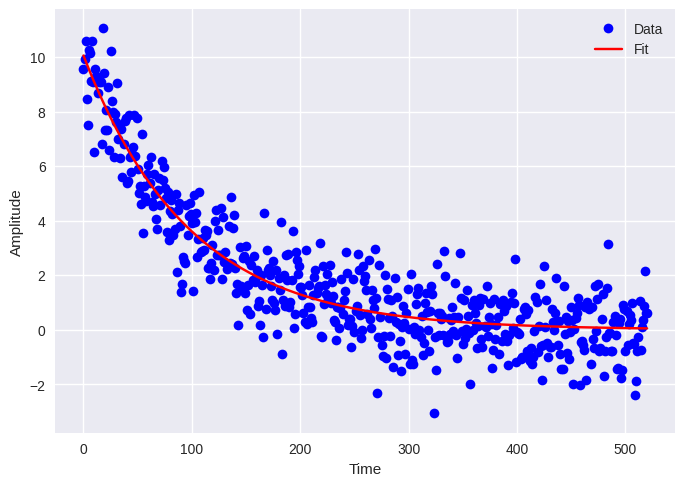

Time constant:  97.47617735876298


In [20]:
x1 = np.arange(0,521, 1)
c_test1 = c_test1[179:]


popt, pcov = curve_fit(func, x1, c_test1)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x1, c_test1, 'bo', label='Data')
plt.plot(x1, func(x1, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)

In [11]:
popt

array([10.05483997, 97.47617736])

array([124])

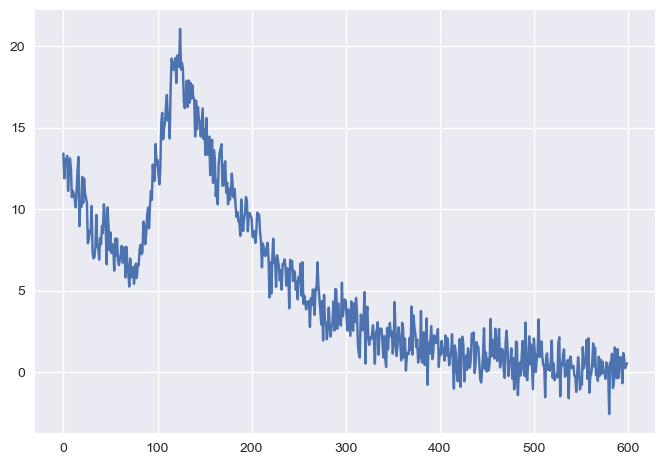

In [168]:
c_test2 = calcium_nsp_noisy[n, 1000:1600]

plt.plot(c_test2)

np.where(c_test2 == np.max(c_test2))[0]

In [ ]:
sav_test1 = sav_test1[179:]
savd_test1 = savd_test1[179:]

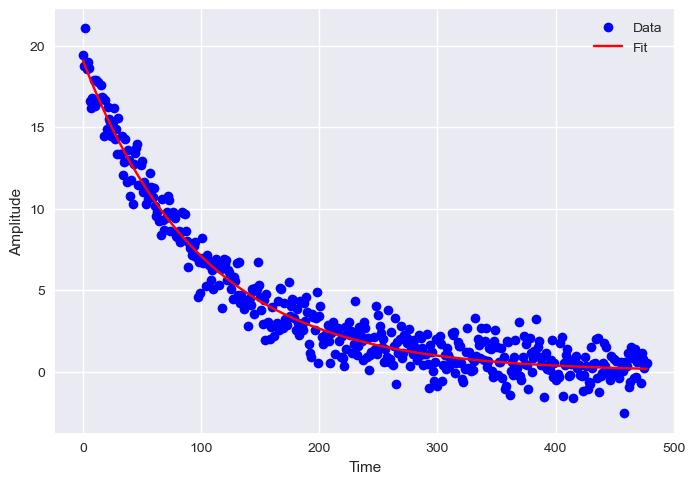

Time constant:  100.86441194656666


In [169]:
x2 = np.arange(0,478, 1)
c_test2 = c_test2[122:]
popt, pcov = curve_fit(func, x2, c_test2)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x2, c_test2, 'bo', label='Data')
plt.plot(x2, func(x2, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)

array([239])

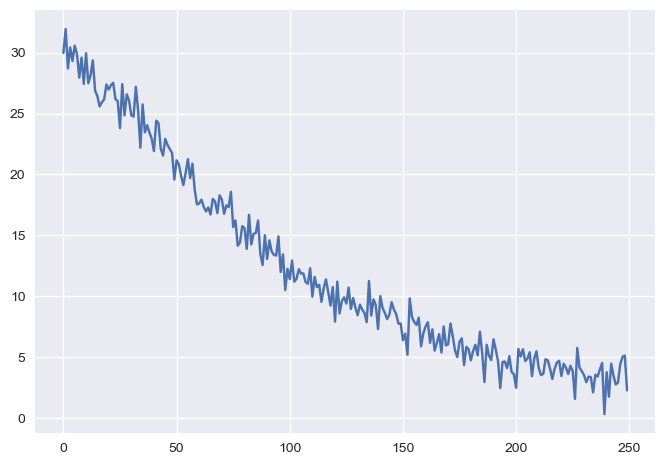

In [170]:
c_test3 = calcium_nsp_noisy[n, 350:600]

plt.plot(c_test3)

np.where(c_test3 == np.min(c_test3))[0]

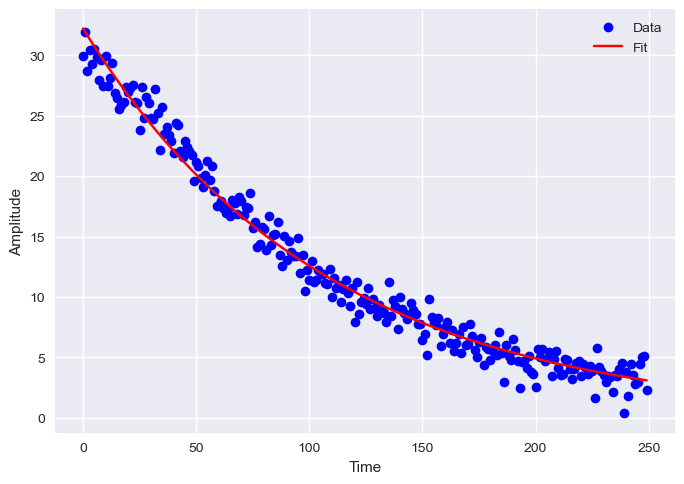

Time constant:  106.28390595853017


In [171]:
x3 = np.arange(0,250, 1)
#c_test2 = c_test2[122:]
popt, pcov = curve_fit(func, x3, c_test3)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x3, c_test3, 'bo', label='Data')
plt.plot(x3, func(x3, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)

In [189]:
aucor = np.correlate(calcium_nsp_noisy[n, :], calcium_nsp_noisy[n,:], mode='full')

aucor /= np.max(aucor)

h_aucor = aucor[int(len(aucor)/2):]
h_aucor = h_aucor[50:200]

#plt.plot(h_aucor)

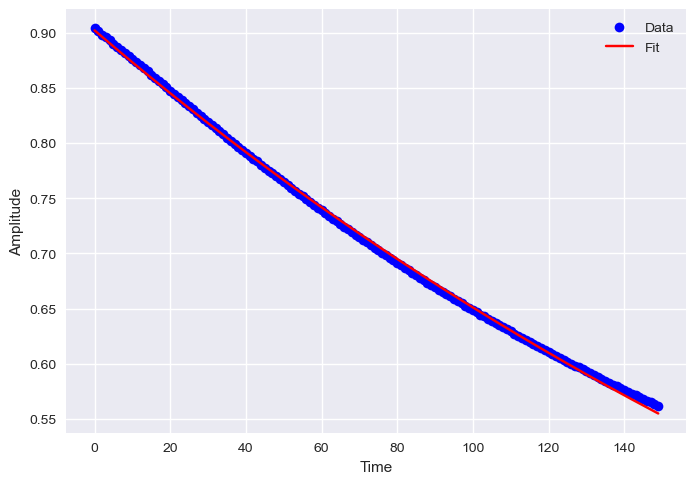

Time constant:  306.263099428118


In [190]:
#x_aucor = np.arange(0,int(len(aucor)/2)+1, 1)
x_aucor = np.arange(0,int(len(h_aucor)), 1)
popt, pcov = curve_fit(func, x_aucor, h_aucor)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x_aucor, h_aucor, 'bo', label='Data')
plt.plot(x_aucor, func(x_aucor, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)

### Derivative method for finding time constant

*** intuitively and by analysis of cut part of the signal in lower blocks we can see the derivative is positive after spikes when the signal is rising. except this part, signal and its derivative can be considered and their own coeficient(we can confirm it by looking at plots of signal and derivative). now by cutting the positive parts of derivative, we can find the coeffiecent as slop of scatter plot, which is the time constant.

signal and its derivative smothed by sav-gol filter

In [3]:
spikes = np.load("spikes-10e4-ms.npy")

N = np.shape(spikes)[0]
wup_time = 1000
spikes = spikes[:, wup_time:]
sim_dur = np.shape(spikes)[1]

noise_intra = np.random.normal(0, 0.01, (N, sim_dur))
spikes_noisy = spikes + noise_intra

calcium = np.zeros((N, sim_dur))
calcium_nsp = np.zeros((N, sim_dur))
tau = 800
dt = 1
const_A = np.exp((-1/tau)*dt)

calcium[:, 0] = spikes[:, 0]
calcium_nsp[:, 0] = spikes[:, 0]

for t in range(1, sim_dur):
    calcium[:, t] = const_A*calcium[:, t-1] + spikes[:, t]


for t in range(1, sim_dur):
    calcium_nsp[:, t] = const_A*calcium_nsp[:, t-1] + spikes_noisy[:, t]


In [4]:
n = 500
#calciumN = calcium[n, :]
noise_recording = np.random.normal(0,1, (N, sim_dur))
calcium_noisy = calcium + noise_recording

#calciumN_nsp = calcium_nsp[n, :]
#noise = np.random.normal(0,1, sim_dur)
calcium_nsp_noisy = calcium_nsp + noise_recording

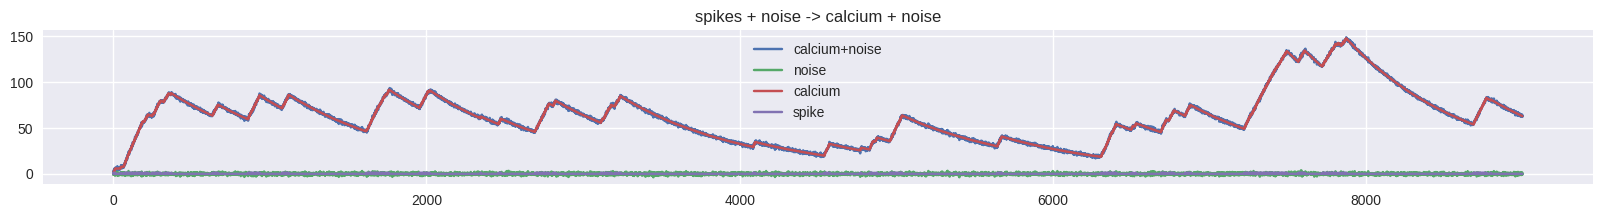

In [5]:
f = plt.figure(figsize=(20,2)) #figure size inside
#ax1 = f.add_axes() #axis limits inside when there is no subplots
#ax1 = plt.subplot(2,1,1) when you want to share axes between subplots you don't use this
ax2 = f.subplots(1)

ax2.set_title('spikes + noise -> calcium + noise')
ax2.plot(calcium_nsp_noisy[n, :], label = 'calcium+noise')
ax2.plot(noise_recording[n, :], label = 'noise')
ax2.plot(calcium_nsp[n, :], label = 'calcium')
ax2.plot(spikes_noisy[n, :], label = 'spike')
ax2.legend()

In [6]:
smooth_cal = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=51, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=51, deriv=1, delta=1., polyorder=3)

x_ncsp = smooth_deriv + (1/tau)*smooth_cal

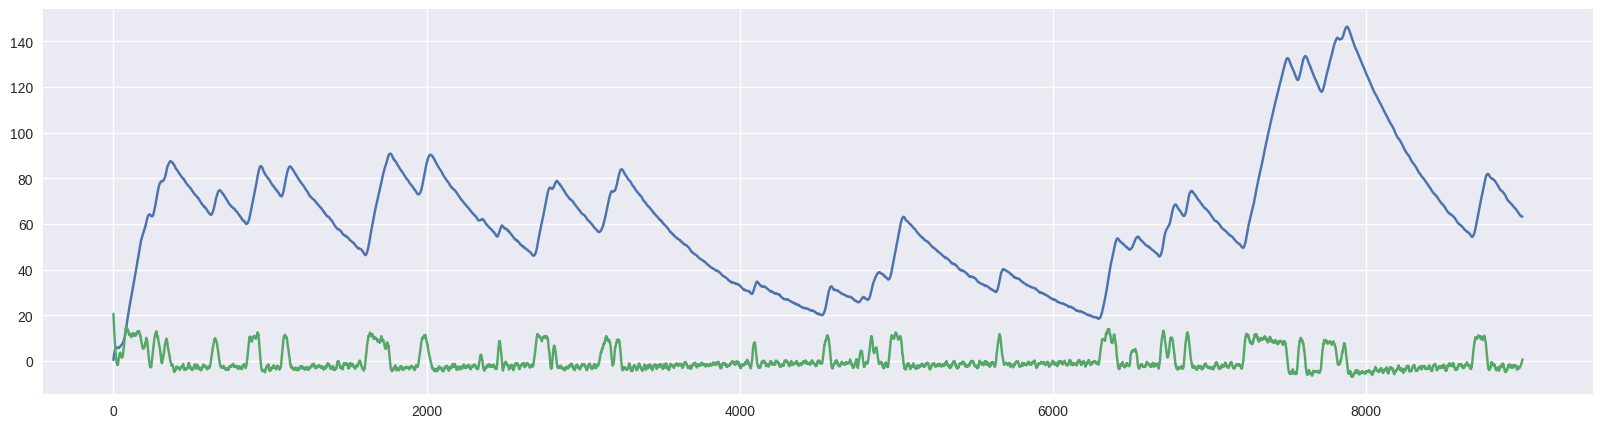

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(smooth_cal)
plt.plot(30*smooth_deriv)

In [8]:
neg_smooth_cal = smooth_cal[smooth_deriv < 0]
neg_smooth_deriv = smooth_deriv[smooth_deriv < 0]

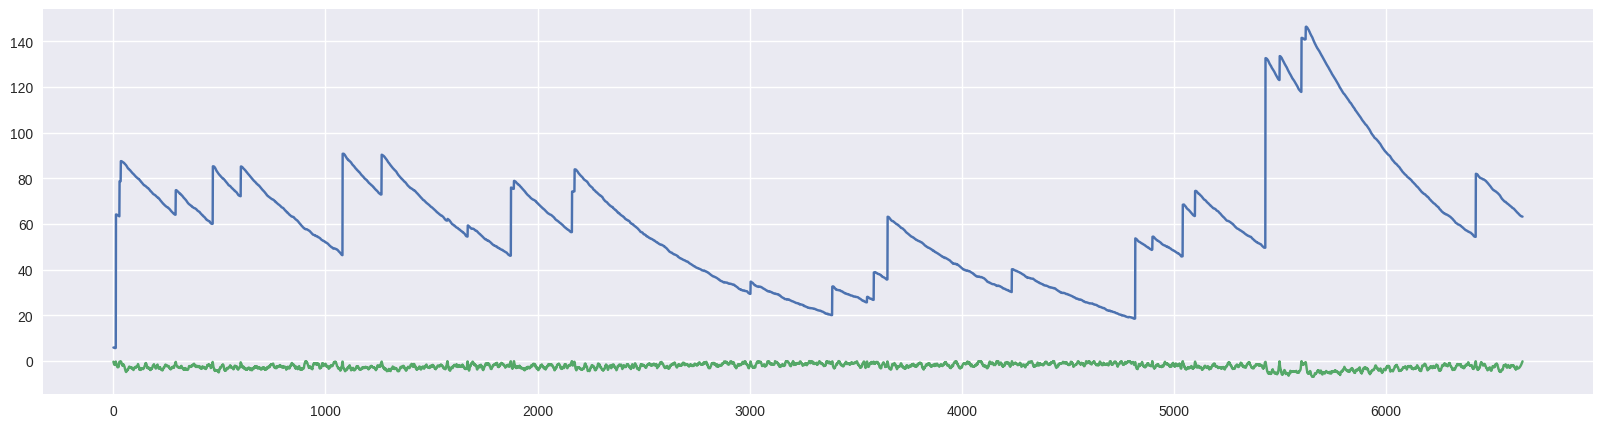

In [9]:
plt.figure(figsize=(20, 5))
plt.plot(neg_smooth_cal)
plt.plot(30*neg_smooth_deriv)

In [10]:
def remove_outliers(x, y, threshold=.05):
    x = np.array(x)
    y = np.array(y)
    residuals = y - np.polyval(np.polyfit(x, y, 1), x)
    quartile_1, quartile_3 = np.percentile(residuals, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (threshold * iqr)
    upper_bound = quartile_3 + (threshold * iqr)
    mask = (residuals >= lower_bound) & (residuals <= upper_bound)
    return x[mask], y[mask]

#x, y = remove_outliers(x, y)

In [11]:
b, a = np.polyfit(smooth_cal, smooth_deriv, deg=1)
b

-0.00027610078883930165

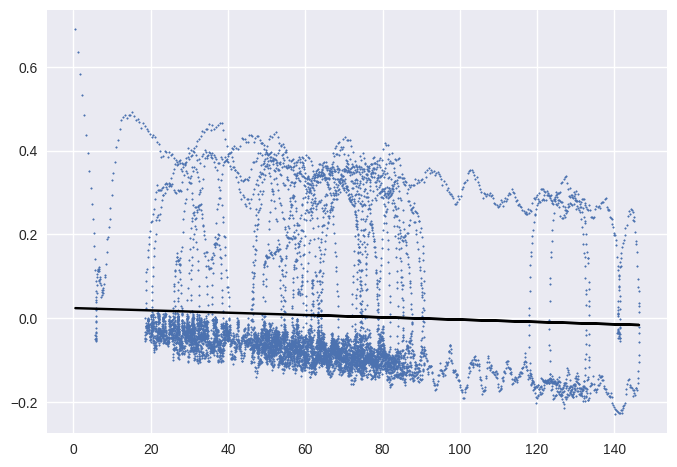

In [12]:
fig, ax = plt.subplots()
ax.scatter(smooth_cal, smooth_deriv, marker='.', s=5)
ax.plot(smooth_cal, a+b*smooth_cal, color='k')

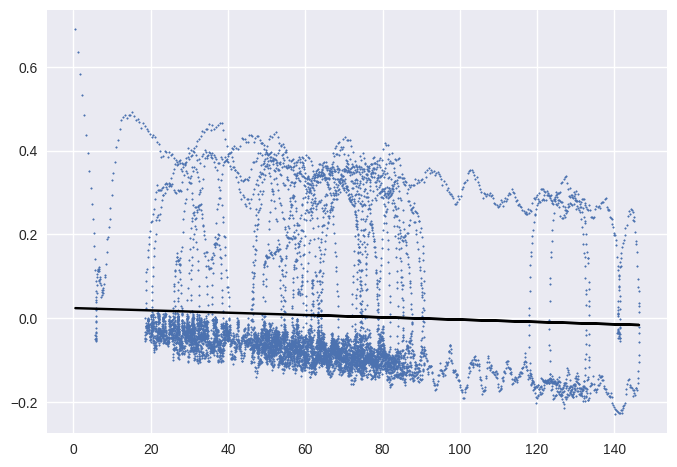

In [13]:
plt.scatter(smooth_cal, smooth_deriv, marker='.', s=5)
plt.plot(smooth_cal, a+b*smooth_cal, color='k')

In [14]:
from scipy import stats

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(smooth_cal, smooth_deriv)

print("Slope:", slope)
print("Intercept:", intercept)


Slope: -0.0002761007888393016
Intercept: 0.02415513088117719


In [15]:
x_out, y_out = remove_outliers(smooth_cal, smooth_deriv, threshold=.5)
b_out, a_out = np.polyfit(x_out, y_out, deg=1)
b_out

-0.0009442125508407472

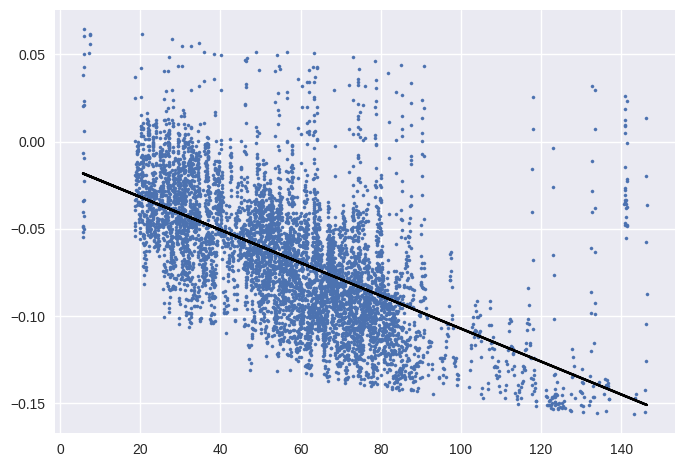

In [16]:
plt.scatter(x_out, y_out, marker='o',s=5)
plt.plot(x_out, a_out+b_out*x_out, color = 'k')

In [17]:
b_neg, a_neg = np.polyfit(neg_smooth_cal, neg_smooth_deriv, deg=1)
b_neg

-0.0011078658981430527

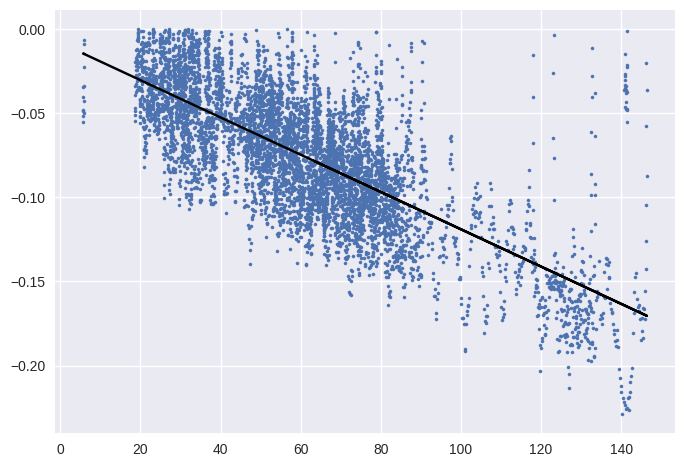

In [18]:
plt.scatter(neg_smooth_cal, neg_smooth_deriv, marker='o', s=5)
plt.plot(neg_smooth_cal, a_neg+b_neg*neg_smooth_cal, color='k')

In [19]:
x_neg_out, y_neg_out = remove_outliers(neg_smooth_cal, neg_smooth_deriv, threshold=1.5)
b, a = np.polyfit(x_neg_out, y_neg_out, deg=1)
b

-0.0012012718355716968

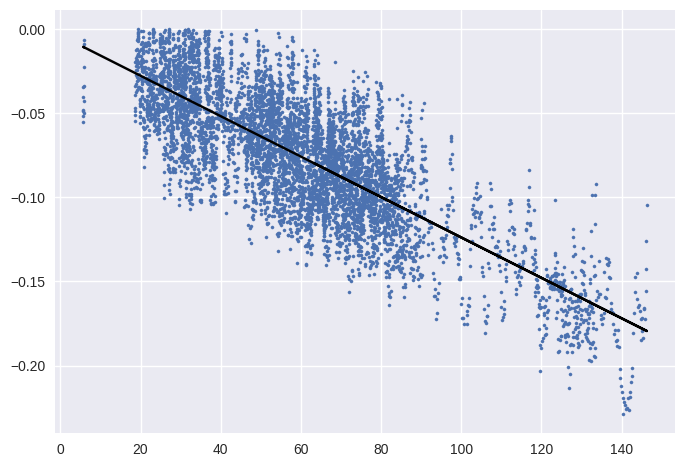

In [20]:
plt.scatter(x_neg_out, y_neg_out, marker='o', s=5)
plt.plot(x_neg_out, a+b*x_neg_out, color ='k')

In [21]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor()
x = np.array(neg_smooth_cal).reshape(-1, 1)
y = np.array(neg_smooth_deriv)
ransac.fit(x, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_x = np.linspace(min(x), max(x), 100).reshape(-1, 1)
line_y = ransac.predict(line_x)

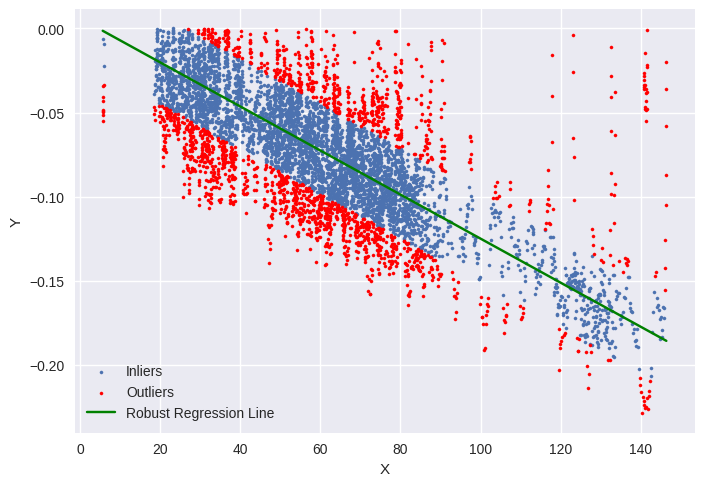

In [22]:
plt.scatter(x[inlier_mask], y[inlier_mask], label='Inliers', marker='o', s=5)
plt.scatter(x[outlier_mask], y[outlier_mask], label='Outliers', color='red', marker='o', s=5)
plt.plot(line_x, line_y, color='green', label='Robust Regression Line')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [23]:
ransac.estimator_.coef_[0]

-0.0013097264308026427

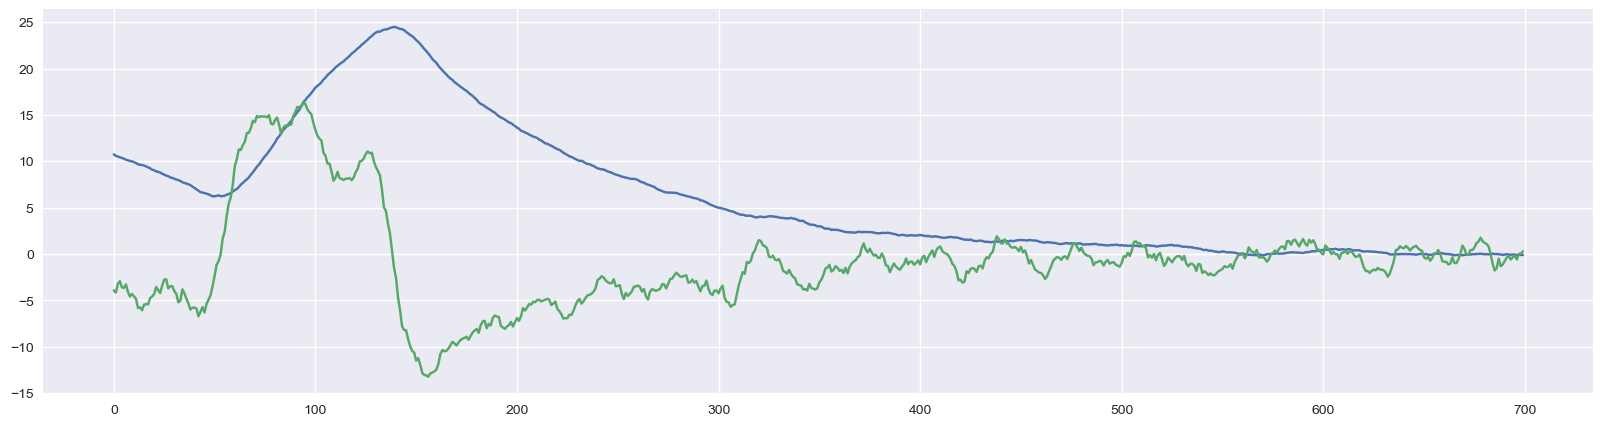

In [47]:
sav_test1 = smooth_cal[4900:5600]
savd_test1 = 50*smooth_deriv[4900:5600]
plt.figure(figsize=(20, 5))
plt.plot(sav_test1)
plt.plot(savd_test1)

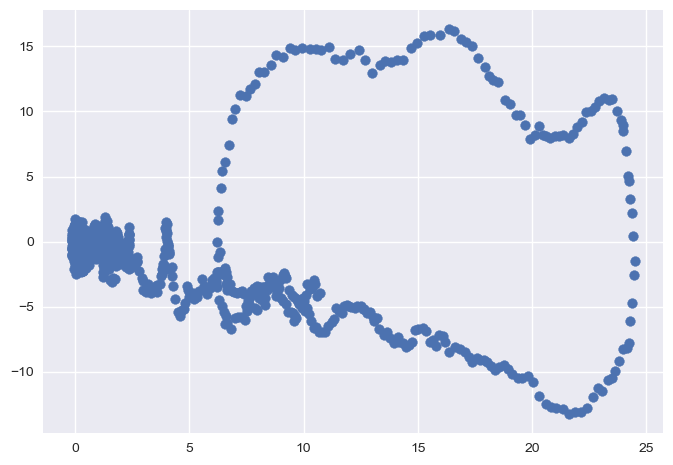

In [48]:
plt.scatter(sav_test1, savd_test1)

signal devided by its derivative and ploted as follows. Histogram is ploted afterwards.

In [278]:
aa = smooth_cal/smooth_deriv

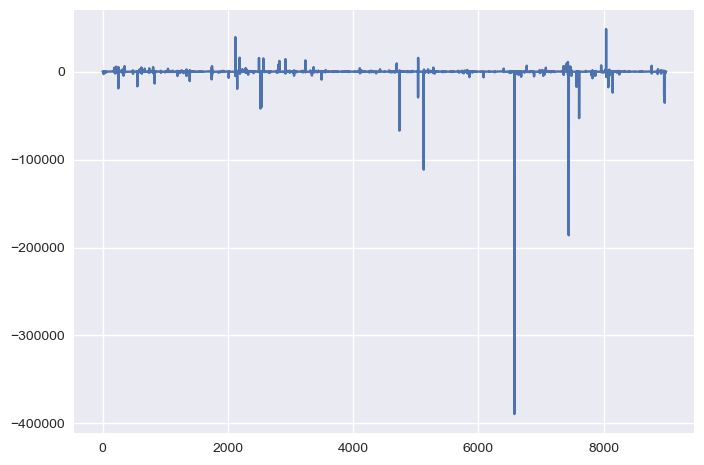

In [279]:
plt.plot(aa)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 1.000e+0

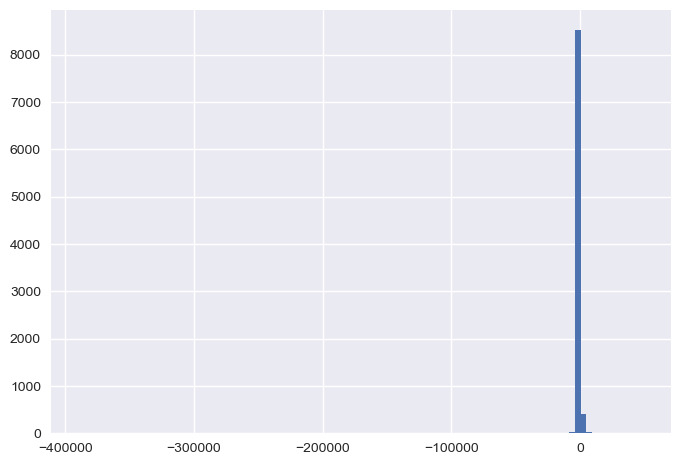

In [208]:
plt.hist(aa, bins=100)

In [220]:
aa_h, aa_bins = np.histogram(aa, bins=100)

based on the frequesncies, I tried to separate values for the bin which its frequency is 406. The argument is that I considered the bin with frequency 8521 az zeros. excluding this part, the most frequent values are for the bin with 406 frequency.

In [221]:
aa_h

array([   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    1,
          0,    0,    2,    1,    0,    2,    1,    4,    2,    4,   22,
       8521,  406,   18,    5,    5,    0,    0,    0,    0,    1,    0,
          1])

(array([250.,  80.,  28.,  16.,   7.,   8.,   5.,   4.,   5.,   3.]),
 array([ 284.96838176,  711.08426869, 1137.20015561, 1563.31604254,
        1989.43192947, 2415.5478164 , 2841.66370333, 3267.77959025,
        3693.89547718, 4120.01136411, 4546.12725104]),
 <BarContainer object of 10 artists>)

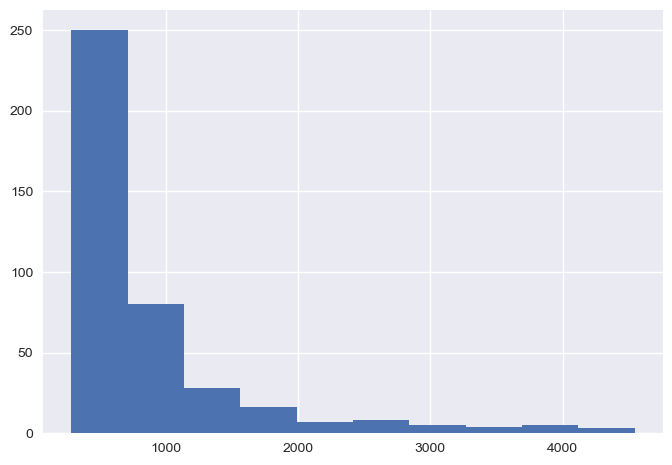

In [239]:
xx = np.where(aa_h == 406)[0][0]
mask = (aa_bins[xx]<aa) & (aa<aa_bins[xx+1])
aa1 = aa[mask]
plt.hist(aa1)

In [242]:
aa1_bins[1]

327.5799704497853

By repeating this procedue for the remaining values we have following.

(array([65., 43., 21., 25., 20., 17., 21., 15., 11., 11.]),
 array([285.89884984, 328.40515295, 370.91145605, 413.41775916,
        455.92406226, 498.43036537, 540.93666848, 583.44297158,
        625.94927469, 668.4555778 , 710.9618809 ]),
 <BarContainer object of 10 artists>)

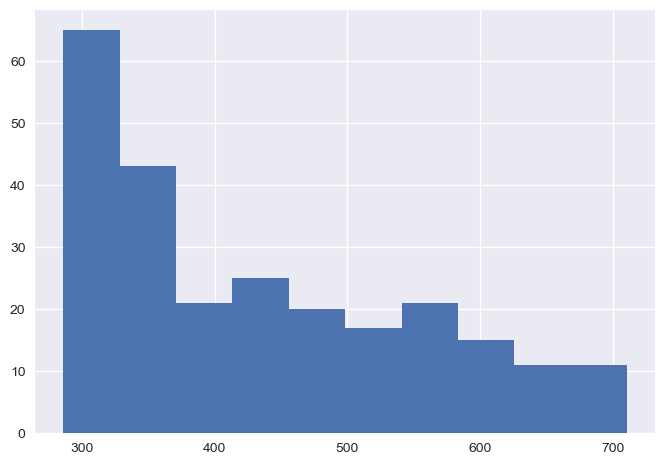

In [243]:
aa1_h, aa1_bins = np.histogram(aa1, bins=10)
aa2 = aa1[(aa1_bins[0]<aa1)&(aa1< aa1_bins[1])]
plt.hist(aa2)

another method

in this method I tried to remove outliers in the histogram in order to have better view of the figure. I removed the first 63 bins which have zero frequency.

In [263]:
test_t = smooth_cal/smooth_deriv

In [264]:
test_hist, test_bins = np.histogram(test_t, bins=100)

test_hist

array([   1,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    1,
          0,    0,    2,    1,    0,    2,    1,    4,    2,    4,   22,
       8521,  406,   18,    5,    5,    0,    0,    0,    0,    1,    0,
          1])

In [267]:
test_t = test_t[test_t > test_bins[64]]

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 9.000e+00,
        1.100e+01, 1.200e+01, 4.500e+01, 2.967e+03, 5.818e+03, 5.300e+01,
        1.800e+01, 1.000e+01, 6.000e+00, 1.000e+01, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

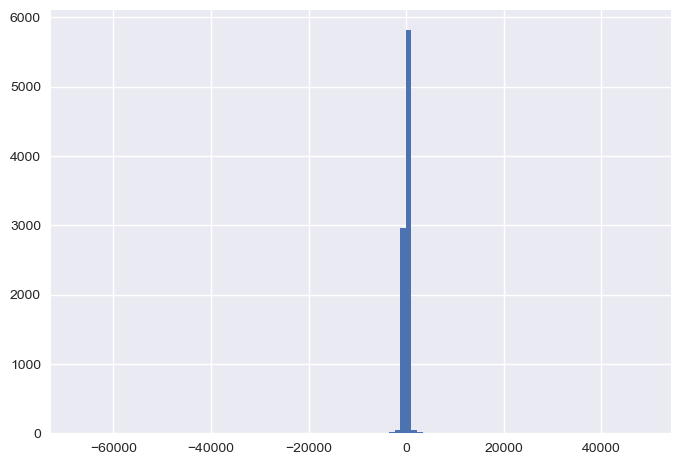

In [268]:
plt.hist(test_t, bins=100)

In [274]:
test_hist_1, test_bins_1 = np.histogram(test_t, bins=100)
np.where(test_hist_1 == 45)

(array([56]),)

other than bins number 56 and 57, I excluded all others as in comparison to these two bins others frequency where negligible. the histogram for the remaining values ploted afterwards.

(array([  1.,   0.,   1.,   0.,   0.,   2.,   0.,   1.,   0.,   1.,   0.,
          1.,   1.,   0.,   0.,   1.,   1.,   0.,   3.,   0.,   1.,   1.,
          0.,   0.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   1.,   1.,   2.,   0.,   0.,   4.,   2.,   1.,   0.,
          2.,   3.,   2.,   2.,   2.,   2.,   3.,   2.,   3.,   1.,   3.,
          2.,   1.,   4.,   4.,   2.,   1.,   2.,   3.,   3.,   4.,   4.,
          8.,   1.,   2.,   7.,   7.,   5.,   6.,   4.,   4.,   5.,   8.,
         11.,   6.,  15.,   9.,  14.,  13.,  14.,  10.,  25.,  30.,  35.,
         26.,  36.,  40.,  56.,  63.,  91., 104., 157., 272., 399., 688.,
        754.]),
 array([-2370.6245692 , -2347.56393394, -2324.50329868, -2301.44266342,
        -2278.38202816, -2255.3213929 , -2232.26075764, -2209.20012238,
        -2186.13948711, -2163.07885185, -2140.01821659, -2116.95758133,
        -2093.89694607, -2070.83631081, -2047.77567555, -2024.71504028,
        -2001.65440502, -1978.

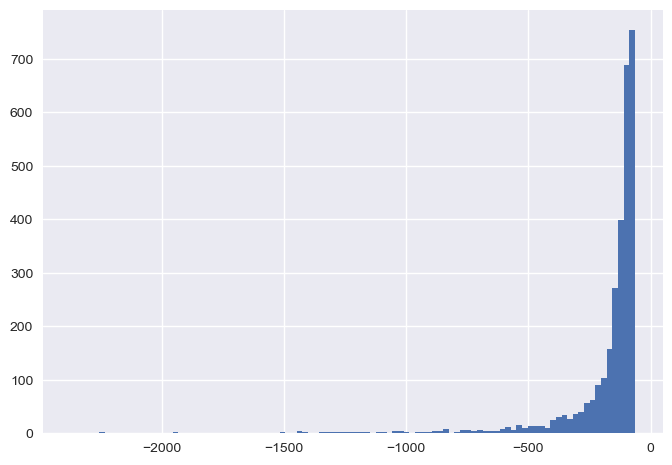

In [276]:
test_x_i = test_bins_1[56]
test_x_f = test_bins_1[58]

test_t = test_t[(test_t > test_x_i)&(test_t<test_x_f)]

plt.hist(test_t, bins=100)

### single spike test

In [110]:
spikes11 = np.zeros((100, 1))
spikes11[50, 0] = 1

N11 = np.shape(spikes11)[1]
sim_dur11 = np.shape(spikes11)[0]

noise_intra11 = np.random.normal(0, 0.01, (N11, sim_dur11))
spikes_noisy11 = spikes11 + noise_intra11

calcium11 = np.zeros((N11, sim_dur11))
calcium_nsp11 = np.zeros((N11, sim_dur11))
tau11 = 100
dt11 = 1
const_A11 = np.exp((-1/tau11)*dt11)

calcium11[:, 0] = spikes11[:, 0]
calcium_nsp11[:, 0] = spikes11[:, 0]

for t in range(1, sim_dur11):
    calcium11[:, t] = const_A11*calcium11[:, t-1] + spikes11[:, t]


for t in range(1, sim_dur11):
    calcium_nsp11[:, t] = const_A11*calcium_nsp11[:, t-1] + spikes_noisy11[:, t]

ValueError: could not broadcast input array from shape (100,) into shape (1,)

In [144]:
spike11 = np.zeros(100)
spikes11[50] = 1

calcium11 = np.zeros(100)
calcium_nsp11 = np.zeros(100)

noise_intra11 = np.random.normal(0, 0.01, 100)
spikes_noisy11 = spikes11 + noise_intra11

tau11 = 100
dt11 = 1
const_A11 = np.exp((-1/tau11)*dt11)

for t in range(1, 100):
    calcium11[t] = const_A11*calcium11[t-1] + spikes11[t]

'''
for t in range(1, 100):
    calcium_nsp11[t] = const_A11*calcium_nsp11[t-1] + spikes_noisy11[t]
'''

'\nfor t in range(1, 100):\n    calcium_nsp11[t] = const_A11*calcium_nsp11[t-1] + spikes_noisy11[t]\n'

In [133]:
noise_intra11 = np.random.normal(0, 0.01, 100)
np.shape(noise_intra11)
np.shape(spike11)

(100,)

In [145]:
spike11[50]

0.0

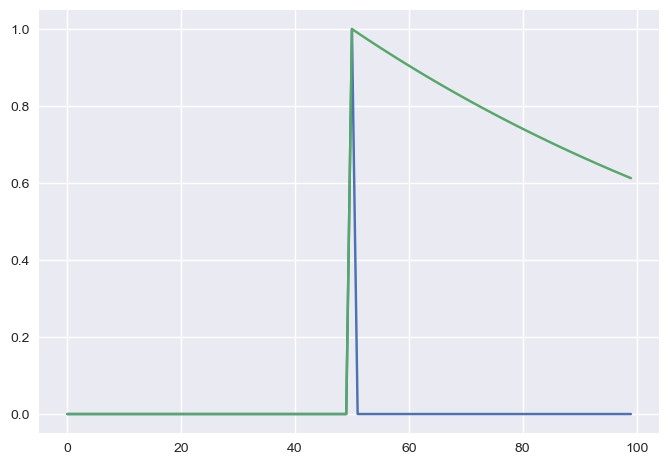

In [146]:
plt.figure()
plt.plot(spikes11)
plt.plot(calcium11)

In [178]:
smooth_cal11 = sig.savgol_filter(calcium11, window_length=31, deriv=0, delta=1., polyorder=3)
smooth_deriv11 = sig.savgol_filter(calcium11, window_length=31, deriv=1, delta=1., polyorder=3)

x_nc11 = smooth_deriv11 + (1/tau)*smooth_cal11

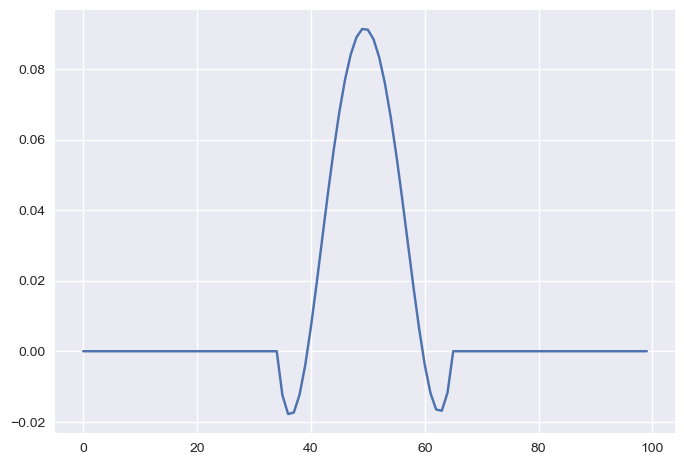

In [179]:
plt.plot(x_nc11)

### Automation of t-constant estimation by curve fitting